In [ ]:
from google.colab import drive
drive.mount('/content/drive') 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import os
import pickle
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import seaborn as sns
from sklearn import metrics

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
## libraries for creating the model
from tensorflow.keras.layers import Bidirectional, Concatenate, Permute, Dot, Input, LSTM, Multiply, MaxPool1D, UpSampling1D
from tensorflow.keras.layers import RepeatVector, Dense, Activation, Lambda, Dropout, Reshape, Conv1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model, Model
import tensorflow.keras.backend as K

In [ ]:
# For reproducibility
np.random.seed(7)
tf.random.set_seed(7)
random.seed(1)

In [ ]:
dir_saved_data = "/content/drive/My Drive/ASHRAEData/data"
dir_saved_model = "/content/drive/My Drive/ASHRAEData/data" 

In [ ]:
## CAN BE CHANGED 

## change these lists as per model's input 
site_id= 0 

## window length 
seq_length = 24 

## name of the model for which data is prepared
model_name = "bi_lstm_model"

In [ ]:
## CAN BE CHANGED 

## parameters required for defining the model
Tx = seq_length ## input sequence length 
Ty = seq_length ## ouput sequence length 
no_of_channels = 13 ## no. of features available for each timestep 
n_a = 8 # number of units for the Encoder Bi-directional LSTM
n_s = 16 # number of units for the Decoder LSTM

BATCH_SIZE_TEST = 32 ## Test batch size
BATCH_SIZE_VAL = 16 ## Validation batch size

In [ ]:
## Creating the model again to load weights
tf.keras.backend.clear_session()

In [ ]:
def softmax(x, axis=1): 
  ## Softmax Function 
  ndim = K.ndim(x)
  if ndim == 2:
    return K.softmax(x)
  elif ndim > 2:
    e = K.exp(x - K.max(x, axis=axis, keepdims=True))
    s = K.sum(e, axis=axis, keepdims=True)
    return e / s
  else:
    raise ValueError('Cannot apply softmax to a tensor that is 1D')

In [ ]:
## to repeat tensor 
repeator = RepeatVector(Tx)

## concatenate tensors 
concatenator = Concatenate(axis=-1)

## Dense Layer -1 for activation step
densor1 = Dense(10, activation = "tanh")

## Dense Layer -2 for activation step
densor2 = Dense(1, activation = "relu")

## Calculate attention Weights 
activator = Activation(softmax, name='attention_weights') 

## Create Context vector 
dotor = Dot(axes = 1)

In [ ]:
def one_step_attention(a, s_prev):

  ## repeat the previous hidden state decoder LSTM 
  s_prev = repeator(s_prev)

  ## concatenate it with the hidden state output of Bi-LSTM encoder 
  concat = concatenator([a,s_prev])
  
  ## calculate intermediate energies 
  e = densor1(concat)
  
  ## calculate energies 
  energies = densor2(e)
  
  ## Calculate the attention weights
  alphas = activator(energies)
  
  ## create context vectors
  context = dotor([alphas,a])
    
  return context

In [ ]:
post_activation_LSTM_cell = LSTM(n_s, return_state = True) # post-attention LSTM (Decoder)

## Ouput Layer
output_layer = Dense(1)

In [ ]:
def generate_model(Tx, Ty, n_a, n_s, no_channels):

  ## Define the inputs to the model 
  X = Input(shape=(Tx, no_channels), name="input")
  s0 = Input(shape=(n_s,), name='s0')
  c0 = Input(shape=(n_s,), name='c0')
  out0 = Input(shape=(1,), name="out0")

  ## copy zero-input vectors to be used in the loop
  s = s0
  c = c0
  out = out0

  ## initialize output  
  outputs = []
  
  ## Pass through the Encoder 
  a =  Bidirectional(LSTM(units=n_a, return_sequences=True))(X)

  ## Calculate Output for all Ty time steps
  for t in range(Ty):
    ## Create context vector for one timestep
    context = one_step_attention(a, s)

    ## use last lutput as the input for the Decoder along with the context vector
    out =  tf.expand_dims(out, 1)
    context = Concatenate(axis = -1)([out,context])

    ## Pass through the Decoder
    s, _, c = post_activation_LSTM_cell(inputs=context , initial_state=[s, c])

    ## Ouput Layer
    out = output_layer(s)
    
    ## store the ouput for all timesteps
    outputs.append(out)

  outputs = Concatenate(axis=-1, name="output")(outputs)

  ## Creating keras.Model instance
  model = Model(inputs=[X, s0, c0, out0], outputs=outputs)
  
  return model

In [ ]:
## Initialize the model
model = generate_model(Tx, Ty, n_a, n_s, no_of_channels)

In [ ]:
## Reading saved data Non-Anomalous
os.chdir(dir_saved_data)

# ## Reading training data
# with open("./" + model_name + "_data/"+ "site_id_" + str(site_id)+"/non_anom/X_train_data.pkl", 'rb') as f:
#   X_train_non_anom = pickle.load(f)

# with open("./" + model_name + "_data/"+ "site_id_" + str(site_id)+"/non_anom/Y_train_data.pkl", 'rb') as f:
#   Y_train_non_anom = pickle.load(f)

## Reading validation data
with open("./" + model_name + "_data/"+ "site_id_" + str(site_id)+"/non_anom/X_val_data.pkl", 'rb') as f:
  X_val_non_anom = pickle.load(f)

with open("./" + model_name + "_data/"+ "site_id_" + str(site_id)+"/non_anom/Y_val_data.pkl", 'rb') as f:
  Y_val_non_anom = pickle.load(f)

## Reading test data
with open("./" + model_name + "_data/"+ "site_id_" + str(site_id)+"/non_anom/X_test_data.pkl", 'rb') as f:
  X_test_non_anom = pickle.load(f)

with open("./" + model_name + "_data/"+ "site_id_" + str(site_id)+"/non_anom/Y_test_data.pkl", 'rb') as f:
  Y_test_non_anom = pickle.load(f)

In [ ]:
## Reading saved data Anomalous
os.chdir(dir_saved_data)

# ## Reading training data
# with open("./" + model_name + "_data/"+ "site_id_" + str(site_id)+"/anom/X_train_data.pkl", 'rb') as f:
#   X_train_anom = pickle.load(f)

# with open("./" + model_name + "_data/"+ "site_id_" + str(site_id)+"/anom/Y_train_data.pkl", 'rb') as f:
#   Y_train_anom = pickle.load(f)

## Reading validation data
with open("./" + model_name + "_data/"+ "site_id_" + str(site_id)+"/anom/X_val_data.pkl", 'rb') as f:
  X_val_anom = pickle.load(f)

with open("./" + model_name + "_data/"+ "site_id_" + str(site_id)+"/anom/Y_val_data.pkl", 'rb') as f:
  Y_val_anom = pickle.load(f)

## Reading test data
with open("./" + model_name + "_data/"+ "site_id_" + str(site_id)+"/anom/X_test_data.pkl", 'rb') as f:
  X_test_anom = pickle.load(f)

with open("./" + model_name + "_data/"+ "site_id_" + str(site_id)+"/anom/Y_test_data.pkl", 'rb') as f:
  Y_test_anom = pickle.load(f)

In [ ]:
os.chdir(dir_saved_model)

In [ ]:
## Loading weights for the model
model.load_weights('./'+ model_name + "/" + "_site_id_"+ str(site_id) + '.ckpt')

In [ ]:
## Creating Test annd Validation tf.dat.Dataset objects to do predictions for Non Anomalous

## creating tf.Dataset objects Test Non Anomalous
s0_test_non_anom = [np.zeros((n_s,)) for i in range(len(X_test_non_anom))]
c0_test_non_anom = [np.zeros((n_s,)) for i in range(len(X_test_non_anom))]
out0_test_non_anom = [np.zeros((1,)) for i in range(len(X_test_non_anom))]

test_dataset_non_anom = tf.data.Dataset.from_tensor_slices(({"input": X_test_non_anom, "s0":s0_test_non_anom, "c0": c0_test_non_anom, "out0": out0_test_non_anom}))

## creating tf.Dataset objects Validation Non Anomalous
s0_val_non_anom = [np.zeros((n_s,)) for i in range(len(X_val_non_anom))]
c0_val_non_anom = [np.zeros((n_s,)) for i in range(len(X_val_non_anom))]
out0_val_non_anom = [np.zeros((1,)) for i in range(len(X_val_non_anom))]

val_dataset_non_anom = tf.data.Dataset.from_tensor_slices(({"input": X_val_non_anom, "s0":s0_val_non_anom   , "c0": c0_val_non_anom, "out0": out0_val_non_anom}))

## Setting the batch size
test_dataset_non_anom = test_dataset_non_anom.batch(BATCH_SIZE_TEST)
val_dataset_non_anom = val_dataset_non_anom.batch(BATCH_SIZE_VAL)

print(test_dataset_non_anom)
print(val_dataset_non_anom)

<BatchDataset shapes: {input: (None, 24, 13), s0: (None, 16), c0: (None, 16), out0: (None, 1)}, types: {input: tf.float64, s0: tf.float64, c0: tf.float64, out0: tf.float64}>
<BatchDataset shapes: {input: (None, 24, 13), s0: (None, 16), c0: (None, 16), out0: (None, 1)}, types: {input: tf.float64, s0: tf.float64, c0: tf.float64, out0: tf.float64}>


In [ ]:
## Creating Test annd Validation tf.dat.Dataset objects to do predictions for Non Anomalous

## creating tf.Dataset objects Test Anomalous
s0_test_anom = [np.zeros((n_s,)) for i in range(len(X_test_anom))]
c0_test_anom = [np.zeros((n_s,)) for i in range(len(X_test_anom))]
out0_test_anom = [np.zeros((1,)) for i in range(len(X_test_anom))]

test_dataset_anom = tf.data.Dataset.from_tensor_slices(({"input": X_test_anom, "s0":s0_test_anom, "c0": c0_test_anom, "out0": out0_test_anom}))

## creating tf.Dataset objects Validation Anomalous
s0_val_anom = [np.zeros((n_s,)) for i in range(len(X_val_anom))]
c0_val_anom = [np.zeros((n_s,)) for i in range(len(X_val_anom))]
out0_val_anom = [np.zeros((1,)) for i in range(len(X_val_anom))]

val_dataset_anom = tf.data.Dataset.from_tensor_slices(({"input": X_val_anom, "s0":s0_val_anom   , "c0": c0_val_anom, "out0": out0_val_anom}))

## Setting the batch size
test_dataset_anom = test_dataset_anom.batch(BATCH_SIZE_TEST)
val_dataset_anom = val_dataset_anom.batch(BATCH_SIZE_VAL)

print(test_dataset_anom)
print(val_dataset_anom)

<BatchDataset shapes: {input: (None, 24, 13), s0: (None, 16), c0: (None, 16), out0: (None, 1)}, types: {input: tf.float64, s0: tf.float64, c0: tf.float64, out0: tf.float64}>
<BatchDataset shapes: {input: (None, 24, 13), s0: (None, 16), c0: (None, 16), out0: (None, 1)}, types: {input: tf.float64, s0: tf.float64, c0: tf.float64, out0: tf.float64}>


In [ ]:
## Validation dataset Non Anomalous Ground Truth
val_arr_0 = np.zeros((1,24))
for i in range(len(Y_val_non_anom)):
  val_arr_0 = np.concatenate([val_arr_0, Y_val_non_anom[i].reshape(1, 24)], axis=0)
val_arr_0 = np.delete(val_arr_0, (0), axis=0)

## Validation dataset Anomalous Ground Truth
val_arr_1 = np.zeros((1,24))
for i in range(len(Y_val_anom)):
  val_arr_1 = np.concatenate([val_arr_1, Y_val_anom[i].reshape(1, 24)], axis=0)
val_arr_1 = np.delete(val_arr_1, (0), axis=0)

In [ ]:
## Test dataset Non Anomalous Ground Truth
test_arr_0 = np.zeros((1,24))
for i in range(len(Y_test_non_anom)):
  test_arr_0 = np.concatenate([test_arr_0, Y_test_non_anom[i].reshape(1, 24)], axis=0)
test_arr_0 = np.delete(test_arr_0, (0), axis=0)

## Test dataset Anomalous Ground Truth
test_arr_1 = np.zeros((1,24))
for i in range(len(Y_test_anom)):
  test_arr_1 = np.concatenate([test_arr_1, Y_test_anom[i].reshape(1, 24)], axis=0)
test_arr_1 = np.delete(test_arr_1, (0), axis=0)

In [ ]:
# outlier label Validation data 
anomaly_label_val = np.concatenate([np.zeros((len(Y_val_non_anom))), np.ones((len(Y_val_anom)))], axis=0)

# outlier label Test Data
anomaly_label_test = np.concatenate([np.zeros((len(Y_test_non_anom))), np.ones((len(Y_test_anom)))], axis=0)

In [ ]:
def calc_mse(y_true,y_pred):
  return ((y_true - y_pred)**2).mean(axis=1)

In [ ]:
## predicted windows Validation - Non Anomalous
pred_val_non_anom = model.predict(val_dataset_non_anom)
#Validation score - Non Anomalous 
val_anomaly_score_non_anom = calc_mse(val_arr_0, pred_val_non_anom)

## predicted windows Validation - Anomalous
pred_val_anom = model.predict(val_dataset_anom)
#Validation score - Anomalous 
val_anomaly_score_anom = calc_mse(val_arr_1, pred_val_anom)

# anomaly score - Validation
val_score = np.concatenate([val_anomaly_score_non_anom, val_anomaly_score_anom], axis=0)

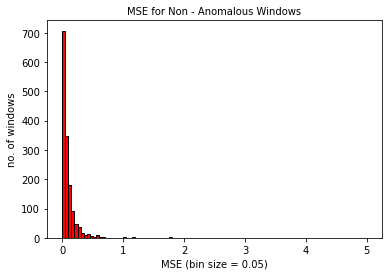

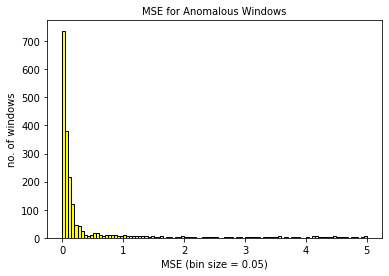

In [ ]:
for i, binwidth in enumerate([0.05]): # log_7
      # Draw the plot
      plt.hist(val_anomaly_score_non_anom, color = 'red', edgecolor = 'black', bins = int((5)/binwidth),range=(0,5), density=False)
      plt.title("MSE for Non - Anomalous Windows", fontsize=10)
      plt.xlabel('MSE (bin size = 0.05)', fontsize=10)
      plt.ylabel('no. of windows', fontsize=10)
      # plt.savefig("Non_Anom_MSE_Model.pdf")
      plt.show()
      plt.hist(val_anomaly_score_anom, color = 'yellow', edgecolor = 'black', bins = int((5)/binwidth),range=(0,5), density=False)
      # , bins = int((5)/binwidth),range=(0,5)
      plt.title("MSE for Anomalous Windows", fontsize=10)
      # # Title and labels
      # plt.title('Histogram with Binwidth ='+ str(binwidth))
      plt.xlabel('MSE (bin size = 0.05)', fontsize=10)
      plt.ylabel('no. of windows', fontsize=10)
      # plt.savefig("Anom_MSE_Model_2.pdf")
      plt.show()

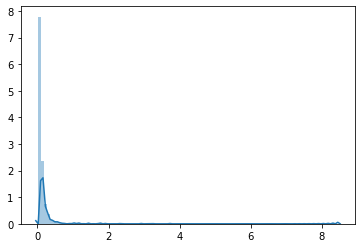

In [ ]:
sns.distplot(val_anomaly_score_non_anom, bins=100)

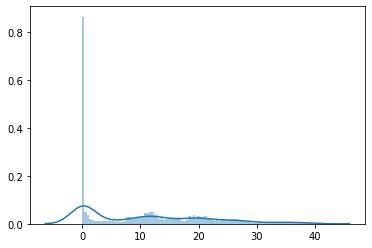

In [ ]:
sns.distplot(val_anomaly_score_anom, bins = 100)

In [ ]:
## predicted windows Test - Non Anomalous
pred_test_non_anom = model.predict(test_dataset_non_anom)
# Test score - Non Anomalous 
test_anomaly_score_non_anom = calc_mse(test_arr_0, pred_test_non_anom)

## predicted windows Test - Anomalous
pred_test_anom = model.predict(test_dataset_anom)
# Test score - Anomalous 
test_anomaly_score_anom = calc_mse(test_arr_1, pred_test_anom)

# anomaly score - Test
test_score = np.concatenate([test_anomaly_score_non_anom, test_anomaly_score_anom], axis=0)

In [ ]:
# set threshold on the validation data 
threshold = 0.8

In [ ]:
print("threshold : ", threshold)
# convet scores to label using the calculated labels 
val_label_pred = (val_score > threshold).astype('int')

threshold :  0.8


In [ ]:
# evaluate and print the results on Validation data 
print("\nOn Validation Data:")
tn, fp, fn, tp = metrics.confusion_matrix(anomaly_label_val, val_label_pred).ravel()
p = tp/(tp+fp)
r = tp/(tp+fn)
f1 = 2*p*r/(p+r)
print("Precision : {}".format(p))
print("Recall : {}".format(r))
print("F1 score : {}".format(f1))


On Validation Data:
Precision : 0.9932088285229203
Recall : 0.6379498364231189
F1 score : 0.7768924302788844


In [ ]:
print("threshold : ", threshold)
# convet scores to label using the calculated labels 
test_label_pred = (test_score > threshold).astype('int')

threshold :  0.8


In [ ]:
# evaluate and print the results on Validation data 
print("\nOn Test Data:")
tn, fp, fn, tp = metrics.confusion_matrix(anomaly_label_test, test_label_pred).ravel()
p = tp/(tp+fp)
r = tp/(tp+fn)
f1 = 2*p*r/(p+r)
print("Precision : {}".format(p))
print("Recall : {}".format(r))
print("F1 score : {}".format(f1))


On Test Data:
Precision : 0.9965706447187929
Recall : 0.6339836688898585
F1 score : 0.7749628557278373
